## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

/bin/sh: wget: command not found


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [12]:
categorical = ['home','marital','records','job']

numerical = ['seniority','time', 'age','expenses', 'income', 'assets', 'debt', 'amount', 'price']

df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [14]:
from sklearn.model_selection import train_test_split

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)

df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

len(df_train),len(df_val),len(df_test)

(2672, 891, 891)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
from sklearn.linear_model import LogisticRegression


for num in numerical:
    X = df_train[num]
    X = X.values.reshape(-1, 1)
    y = df_train['default']
    y = y.values.reshape(-1,1)
    
    model = LogisticRegression()
    model.fit(X,y)
    y_pred = model.predict_proba(X)[:,1]
    
    score = roc_auc_score(y,y_pred)
    
    print(num,score)


seniority 0.7093778624491943
time 0.5608662489595051
age 0.5732933272499939
expenses 0.4990815782782989
income 0.682006666132633
assets 0.6486042567122802
debt 0.49521703242164505
amount 0.5910773431595518
price 0.5043329862114843


/Users/fmjegs/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/fmjegs/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fmjegs/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/fmjegs/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [62]:
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [63]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

train_dicts = df_train[features].to_dict(orient ='records')
X_train = dv.fit_transform(train_dicts)

Val_dict =df_val[features].to_dict(orient ='records')
X_val = dv.transform(Val_dict)

In [64]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
y_pred = model.predict_proba(X_val)[:,1]

In [66]:
roc_auc_score(y_val,y_pred)

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [67]:
#target
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

# prediction
predict_positive = (y_pred>= 0.5)
predict_negative = (y_pred < 0.5)

In [68]:
tp = (actual_positive & predict_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (actual_negative & predict_positive).sum()
fn = (actual_positive & predict_negative).sum()

In [86]:
scores=[]

for t in range(0,100,1):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred>= (t/100))
    predict_negative = (y_pred < (t/100))
    
    tp = (actual_positive & predict_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    
    scores.append(((t/100),tp,tn,fp,fn))

In [87]:
column = ['Threshold','tp','tn','fp','fn']
df_scores = pd.DataFrame(scores,columns = column)

In [97]:
df_scores['TPR'] = df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['FPR'] = df_scores.fp/(df_scores.fp +df_scores.tn)
df_scores['Precision'] = df_scores.tp/(df_scores.tp+df_scores.fp)
df_scores

,Threshold,tp,tn,fp,fn,TPR,FPR,Recall,Precision
0,0.00,246,0,645,0,1.00000,1.000000,0.276094,0.276094
1,0.01,246,10,635,0,1.00000,0.984496,0.279228,0.279228
2,0.02,244,32,613,2,0.99187,0.950388,0.284714,0.284714
3,0.03,242,52,593,4,0.98374,0.919380,0.289820,0.289820
4,0.04,242,82,563,4,0.98374,0.872868,0.300621,0.300621
...,...,...,...,...,...,...,...,...,...
95,0.95,0,645,0,246,0.00000,0.000000,NaN,NaN
96,0.96,0,645,0,246,0.00000,0.000000,NaN,NaN
97,0.97,0,645,0,246,0.00000,0.000000,NaN,NaN
98,0.98,0,645,0,246,0.00000,0.000000,NaN,NaN


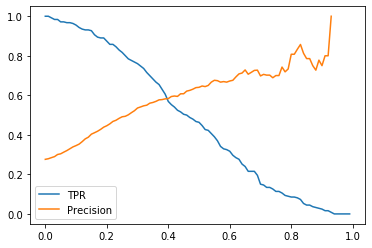

In [99]:
plt.plot(df_scores.Threshold,df_scores.TPR, label ='TPR')
plt.plot(df_scores.Threshold,df_scores.Precision, label ='Precision')
plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [100]:
for t in df_scores.Threshold:
    df_scores['F_Score'] = 2*((df_scores.Precision*df_scores.TPR)/(df_scores.Precision+df_scores.TPR))

In [104]:
 df_scores

,Threshold,tp,tn,fp,fn,TPR,FPR,Recall,Precision,F_Score
0,0.00,246,0,645,0,1.00000,1.000000,0.276094,0.276094,0.432718
1,0.01,246,10,635,0,1.00000,0.984496,0.279228,0.279228,0.436557
2,0.02,244,32,613,2,0.99187,0.950388,0.284714,0.284714,0.442430
3,0.03,242,52,593,4,0.98374,0.919380,0.289820,0.289820,0.447734
4,0.04,242,82,563,4,0.98374,0.872868,0.300621,0.300621,0.460514
...,...,...,...,...,...,...,...,...,...,...
95,0.95,0,645,0,246,0.00000,0.000000,NaN,NaN,NaN
96,0.96,0,645,0,246,0.00000,0.000000,NaN,NaN,NaN
97,0.97,0,645,0,246,0.00000,0.000000,NaN,NaN,NaN
98,0.98,0,645,0,246,0.00000,0.000000,NaN,NaN,NaN


Text(0, 0.5, 'F_Score')

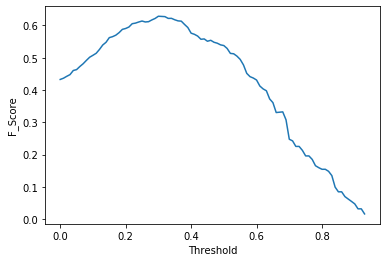

In [103]:
plt.plot(df_scores.Threshold,df_scores.F_Score, label ='F_score')
plt.xlabel('Threshold')
plt.ylabel('F_Score')

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [121]:
def train(df_train,y_train):
    dicts = df_train[categorical+numerical].to_dict(orient ='records')
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv,model

In [122]:
def predict(df,dv,model):
    
    dicts = df[categorical+numerical].to_dict(orient ='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [123]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5,shuffle=True,random_state=1)

scores =[]

for train_idx,val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train =  df_train.default.values
    y_val = df_val.default.values
    
    dv,model = train(df_train,y_train)
    
    y_pred =  predict(df_val,dv,model)
    
    
    auc = roc_auc_score(y_val,y_pred)
    
    scores.append(auc)

In [124]:
scores

[0.8546183546183547,
 0.8645094650696223,
 0.8300518134715026,
 0.8564536414730968,
 0.818240296657869]

In [126]:
round(np.std(scores),3)

0.018

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.